In [ ]:
##Mount drive with Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
## Copying the database file to the /content directory
!cp gdrive/My\ Drive/ML\ Revision/Amazon\ Fine\ Food\ Review/processed_df.csv /content

In [ ]:
import bs4
import torch.nn as nn
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,re,json
import torch.nn as nn
import shutil
from torch.utils.data import TensorDataset,DataLoader
import gc,time
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score,accuracy_score
from collections import Counter
from sklearn.model_selection import train_test_split
import seaborn as sns

from bs4 import BeautifulSoup

In [ ]:
df = pd.read_csv('processed_df.csv')
#dropping null values
df = df.dropna(axis=0)
df.head()

,Time,CleanText,Score
0,1256688000,book purchased birthday gift year old boy sque...,1
1,1025481600,daughter loves really rosie books introduced r...,1
2,1129507200,one best children books ever written mini vers...,0
3,1348358400,title chicken soup riceauthor maurice sendakre...,1
4,1191456000,fun way children learn months year learn poems...,1


In [ ]:
df.shape

(347326, 3)

In [ ]:

df['Time'] = pd.to_datetime(df['Time'],unit='s')
df = df.sort_values('Time')
df = df.reset_index(drop=True)
df.shape

(347326, 3)

In [ ]:
df.head(3)

,Time,CleanText,Score
0,1999-10-08,witty little book makes son laugh loud recite ...,1
1,1999-10-25,remember seeing show aired television years ag...,1
2,1999-12-02,beetlejuice well written movie everything exce...,1


In [ ]:
X = df['CleanText']
y = df['Score']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=100)
# X_tr,X_cv,y_tr,y_cv = train_test_split(X_train,y_train,test_size=0.3,stratify=y_train,random_state=100)
print(f'shape of X_train is {X_train.shape}')
print(f'shape of X_test is {X_test.shape}')
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train is (243128,)
shape of X_test is (104198,)
shape of y_train is (243128,)
shape of y_test is (104198,)


In [ ]:
#helper functions
def tockenize(X_train,X_test):
  """
  bow encoding
  """
  word_list = []
  for sent in X_train:
    for word in sent.split():
      word_list.append(word)

  corpus = Counter(word_list)
  # sorting on the basis of most common words
  corpus_ = sorted(corpus,key=corpus.get,reverse=True)
  # creating a dict
  onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

  train_vec = []
  test_vec = []
  for sent in X_train:
      train_vec.append([onehot_dict[word] for word in sent.split() if word in onehot_dict.keys()])

  for sent in X_test:
      test_vec.append([onehot_dict[word] for word in sent.split() if word in onehot_dict.keys()])

  return train_vec,test_vec,onehot_dict

def padding_(sentences, seq_len):
    """
    do padding on left handside
    ie, if seq_len = 5 and input is [1,2,3] out will be [0,0,1,2,3]

    """
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [ ]:
# encoding
X_train = X_train.values
X_test = X_test.values
train_seq,test_seq,corpus_dict = tockenize(X_train,X_test)
corpus = [i for i in corpus_dict.keys()]
print(f'Total number of words {len(corpus)}')

Total number of words 94853


In [ ]:
# saving dict for future use
import json
# convert into JSON:
with open("corpus_dict", "w") as fp:
    json.dump(corpus_dict,fp)

In [ ]:
#example
print(X_train[162])
print(train_seq[162])

not huge tea drinker tried
[1, 458, 11, 887, 28]


In [ ]:
rev_len = [len(i) for i in train_seq]

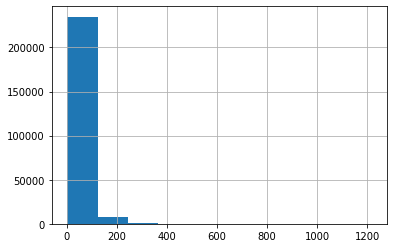

In [ ]:
pd.Series(rev_len).hist()
plt.show()

In [ ]:
pd.Series(rev_len).describe()

count    243128.000000
mean         39.316903
std          38.123968
min           1.000000
25%          17.000000
50%          28.000000
75%          48.000000
max        1217.000000
dtype: float64

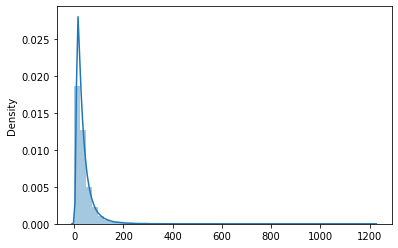

In [ ]:
sns.distplot(rev_len)

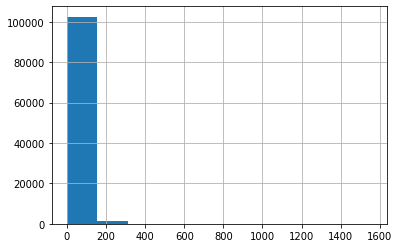

count    104198.000000
mean         38.950824
std          37.898811
min           1.000000
25%          17.000000
50%          28.000000
75%          48.000000
max        1557.000000
dtype: float64


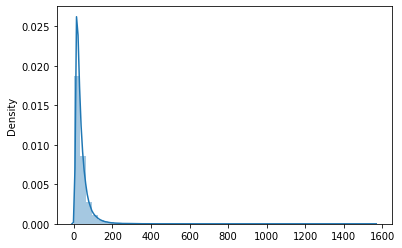

In [ ]:
rev_len = [len(i) for i in test_seq]
pd.Series(rev_len).hist()
plt.show()
print(pd.Series(rev_len).describe())
sns.distplot(rev_len)
plt.show()

In [ ]:
# padding (we will pad to a length of 224)
seq_train_pad = padding_(np.array(train_seq),225)
seq_test_pad = padding_(np.array(test_seq),225)

In [ ]:
seq_train_pad[163]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

# Using Pretrained weight embeddings

## Download Glove vector file

In [ ]:
#!wget http://nlp.stanford.edu/data/wordvecs/glove.42B.300d.zip

In [ ]:
# Save a copy of Glove Vector to drive.
#!cp glove.42B.300d.zip gdrive/My\ Drive/ML\ Revision/Amazon\ Fine\ Food\ Review/

In [ ]:
#Unzip the file
#!unzip glove.42B.300d.zip

In [ ]:
#ls

In [ ]:
##code from https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python
#def loadGloveModel(File):
#    print("Loading Glove Model")
#    f = open(File,'r')
#    gloveModel = {}
#    for line in f:
#        splitLines = line.split()
#        word = splitLines[0]
#        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
#        gloveModel[word] = wordEmbedding
#    print(len(gloveModel)," words loaded!")
#    return gloveModel
#
#glove_dict =  loadGloveModel("glove.42B.300d.txt")
#gc.collect()

In [ ]:
#embedding_matrix = np.zeros((len(corpus) + 1, 300))
#for i,word in enumerate(corpus):
#  if word in glove_dict.keys():
#    embedding_vec = glove_dict[word]
#    embedding_matrix[i] = embedding_vec
#
# 
#print(embedding_matrix.shape)  
#
#np.save('embedding_matrix_model.npy',embedding_matrix)

In [ ]:
# Save a copy of Glove Vector to drive.
#!cp embedding_matrix_model.npy gdrive/My\ Drive/ML\ Revision/Amazon\ Fine\ Food\ Review/

# Model

In [ ]:
!cp gdrive/My\ Drive/ML\ Revision/Amazon\ Fine\ Food\ Review/embedding_matrix_model.npy /content/

In [ ]:
#loading embedding
embedding_matrix = np.load('embedding_matrix_model.npy')


final_train = seq_train_pad
final_test = seq_test_pad
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(final_train), torch.from_numpy(y_train.values))
test_data = TensorDataset(torch.from_numpy(final_test), torch.from_numpy(y_test.values))

# dataloaders
batch_size = 500

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data,  batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data,  batch_size=batch_size, shuffle=True )

In [ ]:
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

torch.Size([500, 225])
torch.Size([500])


# Model 1

In [ ]:
class Network(nn.Module):
  def __init__(self,embedding_matrix,hidden_dim,no_layers=1):
    super().__init__()
    vocab_size = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]
    self.hidden_dim = hidden_dim
    self.n_layers = no_layers
    self.embedding = nn.Embedding(vocab_size,embedding_dim)
    self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
    self.embedding.weight.requires_grad = False

    self.lstm = nn.LSTM(embedding_dim,hidden_size=self.hidden_dim,batch_first=True,num_layers=self.n_layers)
    self.dropout = nn.Dropout(0.2)
    self.linear1 = nn.Linear(self.hidden_dim,self.hidden_dim//2)
    self.linear2 = nn.Linear(self.hidden_dim//2,2)

  def forward(self,x):
    batch_size= x.shape[0]     #batch_size,seq_len
    x = self.embedding(x)      #batch_size,seq_len,embed_dim
    lstm_out,h = self.lstm(x)  #batch_size,seq_len,hidden_dim*no_layers 
    lstm_out = self.dropout(lstm_out)
    lstm_out = lstm_out.contiguous().view(-1,self.hidden_dim)  #batch_size*seq_len*no_layers,hidden_dim
    out = self.linear1(lstm_out)   #batch_size*seq_len*no_layers, out_dim
    out = self.linear2(out)
    out = out.view(batch_size,-1) #batch_size,seq_len*out_dim*no_layers
    return out[:,-2:]

In [ ]:
class TNetwork(nn.Module):
  def __init__(self,embedding_matrix,hidden_dim,no_layers=1):
    super().__init__()
    vocab_size = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]
    self.hidden_dim = hidden_dim
    self.n_layers = no_layers
    self.embedding = nn.Embedding(vocab_size,embedding_dim)
    self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
    self.embedding.weight.requires_grad = False

    self.lstm = nn.LSTM(embedding_dim,hidden_size=self.hidden_dim,batch_first=True,num_layers=self.n_layers)
    self.dropout = nn.Dropout(0.2)
    self.linear1 = nn.Linear(self.hidden_dim,self.hidden_dim//2)
    self.linear2 = nn.Linear(self.hidden_dim//2,2)

  def forward(self,x):
    batch_size= x.shape[0]     #batch_size,seq_len
    x = self.embedding(x)      #batch_size,seq_len,embed_dim
    lstm_out,h = self.lstm(x)  #batch_size,seq_len,hidden_dim*no_layers 
    lstm_out = self.dropout(lstm_out)
    lstm_out = lstm_out.contiguous().view(-1,self.hidden_dim)  #batch_size*seq_len*no_layers,hidden_dim
    out = self.linear1(lstm_out)   #batch_size*seq_len*no_layers, out_dim
    out = self.linear2(out)
    out = out.view(batch_size,-1) #batch_size,seq_len*out_dim*no_layers
    return out[:,-2:]

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = TNetwork(embedding_matrix,hidden_dim=100,no_layers=2)
model = model.to(device)
model

TNetwork(
  (embedding): Embedding(94854, 300)
  (lstm): LSTM(300, 100, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=100, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=2, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(params=parameters,lr=0.001)


# helper functions
#function to calculate auc and accuracy
def score(y,y_pred,y_prob_pred):
  roc_score = roc_auc_score(y,y_prob_pred)
  acc = accuracy_score(y,y_pred)
  return roc_score, acc

def save_ckp(state, is_best, checkpoint_path, best_model_path):
  """
  state: checkpoint we want to save
  is_best: is this the best checkpoint; min validation loss
  checkpoint_path: path to save checkpoint
  best_model_path: path to save best model
  """
  # save checkpoint data to the path given, checkpoint_path
  torch.save(state, checkpoint_path)
  # if it is a best model, min validation loss
  if is_best:
  # copy that checkpoint file to best path given, best_model_path
      shutil.copyfile(checkpoint_path, best_model_path)

In [ ]:
mkdir models

In [ ]:
ls

corpus_dict                 gdrive/           sample_data/
embedding_matrix_model.npy  processed_df.csv


In [ ]:
metrics = {'train_auc': [],'test_auc' : [], 'train_accuracy':[], 'test_accuracy':[], 'train_loss':[],'test_loss': []}
epochs = 5
checkpoint_path = 'models/chkpoint1_'
best_model_path = 'models/bestmodel1.pt'
test_loss_min = np.Inf

for epoch in range(epochs):
    start_time = time.time()
    print(f'Epoch {epoch + 1}')
    AUC = 0.0 
    ACC = 0.0
    LOSS = 0.0
    model.train()
    for x,y in train_loader:
        batch_size = x.shape[0]
        x = x.long()
        y = y.long()
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred,y)
        loss.backward()
        # nn.utils.clip_grad_norm(model.parameters(), clip)
        optimizer.step()
        _, y_hat_pred = torch.max(y_pred,axis=1)
        y_hat_prob = y_pred[:,-1]
        y_, y_hat_pred_,y_hat_prob_ = y.detach(), y_hat_pred.detach(), y_hat_prob.detach()
        auc_score, acc = score(y_.cpu().numpy(), y_hat_pred_.cpu().numpy(), y_hat_prob_.cpu().numpy())
        ACC += (acc * batch_size)
        LOSS += (loss * batch_size)
        AUC += (auc_score * batch_size)

    epoch_auc = AUC / len(train_loader.dataset)
    train_epoch_loss = LOSS / len(train_loader.dataset)
    epoch_accuracy = ACC / len(train_loader.dataset)
    metrics['train_auc'].append(epoch_auc)
    metrics['train_accuracy'].append(epoch_accuracy)
    metrics['train_loss'].append(train_epoch_loss)
    print(f'Train:  Loss: {train_epoch_loss}, Accuracy: {epoch_accuracy}, AUC: {epoch_auc}')


    AUC = 0.0 
    ACC = 0.0
    LOSS = 0.0
    model.eval()
    with torch.no_grad():
      for x,y in test_loader:
        batch_size = x.shape[0]
        x = x.long()
        y = y.long()
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred,y)
        _, y_hat_pred = torch.max(y_pred,axis=1)
        y_hat_prob = y_pred[:,-1]
        y_, y_hat_pred_,y_hat_prob_ = y.detach(), y_hat_pred.detach(), y_hat_prob.detach()  # detaching from torch graph to use it for calculation auc
        auc_score, acc = score(y_.cpu().numpy(), y_hat_pred_.cpu().numpy(), y_hat_prob_.cpu().numpy())
        ACC += (acc * batch_size)
        LOSS += (loss * batch_size)
        AUC += (auc_score * batch_size)

    epoch_auc = AUC / len(test_loader.dataset)
    test_epoch_loss = LOSS / len(test_loader.dataset)
    epoch_accuracy = ACC / len(test_loader.dataset)

    metrics['test_auc'].append(epoch_auc)
    metrics['test_accuracy'].append(epoch_accuracy)
    metrics['test_loss'].append(test_epoch_loss)
    print(f'Validation Loss: {test_epoch_loss}, Accuracy: {epoch_accuracy}, AUC: {epoch_auc}')
    #save checkpoint
    checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': test_epoch_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    if test_epoch_loss <= train_epoch_loss and test_epoch_loss <= test_loss_min:
        print('Validation loss decreased ({:.6f}).  Saving model ...'.format(test_epoch_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        test_loss_min = test_epoch_loss

    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('--'*50)

Epoch 1
Train:  Loss: 0.20893052220344543, Accuracy: 0.9164760948965154, AUC: 0.9445870330950378
Validation Loss: 0.19354525208473206, Accuracy: 0.9228488070788307, AUC: 0.9488922343786059
Validation loss decreased (0.193545).  Saving model ...
1m 4s
----------------------------------------------------------------------------------------------------
Epoch 2
Train:  Loss: 0.18243157863616943, Accuracy: 0.9282682373070975, AUC: 0.9588196256803699
Validation Loss: 0.18349775671958923, Accuracy: 0.9262749764870727, AUC: 0.9564615840947545
1m 4s
----------------------------------------------------------------------------------------------------
Epoch 3
Train:  Loss: 0.16530270874500275, Accuracy: 0.935227534467441, AUC: 0.9658995040273199
Validation Loss: 0.17761212587356567, Accuracy: 0.9311407128735676, AUC: 0.9591339156210337
1m 6s
----------------------------------------------------------------------------------------------------
Epoch 4
Train:  Loss: 0.15174759924411774, Accuracy: 0.94

In [ ]:
ls models

bestmodel1.pt  chkpoint1_


In [ ]:
mv models/chkpoint1_ models/weight

In [ ]:
ls models

bestmodel1.pt  weight


In [ ]:
! cp models/weight gdrive/My\ Drive/ML\ Revision/Amazon\ Fine\ Food\ Review/models

# Predict

In [ ]:
# replacing some phrases like won't with will not

def html_tag(phrase):
    http_remove = re.sub(r"http\S+", "",phrase)
    html_remove = BeautifulSoup(http_remove, 'lxml').get_text()
    return html_remove

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])




In [ ]:
def predict(sentance,seq_len,corpus_dict_):
  sentance = html_tag(sentance)
  sentance = decontracted(sentance)
  # removing extra spaces and numbers
  sentance = re.sub("\S*\d\S*", "", sentance).strip()
  # removing non alphabels
  sentance = re.sub('[^A-Za-z]+', ' ', sentance)
  text = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)

  seq = [corpus_dict_[word] for word in text.split() if word in corpus_dict_.keys()]

  #padding
  padd = np.zeros((1,seq_len),dtype=int)
  padd[0][-len(seq):] = seq
  padd = torch.from_numpy(padd)
  #prediction
  padd = padd.to(device)
  y_pred = model(padd)

  #returning probability and class
  prob = y_pred[:,-1]
  prob = F.sigmoid(prob)
  prob = prob.detach().cpu().numpy()[0]
  label = 'positive' if prob >= 0.5 else 'negative'
  prob = prob if label == 'positive' else 1-prob
  return [label,prob]

In [ ]:
ls models

bestmodel1.pt  chkpoint1_


In [ ]:
cp corpus_dict gdrive/My\ Drive/ML\ Revision/Amazon\ Fine\ Food\ Review/

In [ ]:
!cp -r models/ gdrive/My\ Drive/ML\ Revision/Amazon\ Fine\ Food\ Review/

In [ ]:
#loading embedding
embedding_matrix = np.load('embedding_matrix_model.npy')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Network(embedding_matrix,hidden_dim=100,no_layers=1)
model = model.to(device)
checkpoint_fpath = 'models/chkpoint1_'
checkpoint = torch.load(checkpoint_fpath,map_location=device)

In [ ]:
model

Network(
  (embedding): Embedding(94854, 300)
  (lstm): LSTM(300, 100, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=100, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=2, bias=True)
)

In [ ]:
model.load_state_dict(checkpoint['state_dict'])
model

Network(
  (embedding): Embedding(94854, 300)
  (lstm): LSTM(300, 100, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=100, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=2, bias=True)
)

In [ ]:
input_text = "it was an awesome cookie with apple flavour 234 ideally and i loved it very much and i won't suggest it to everyone"
# Opening JSON file 
with open('corpus_dict') as json_file: 
    corpus_dict_ = json.load(json_file)


out = predict(input_text,225,corpus_dict_)
print(f'Predicted  as class {out[0]} with a probability of {out[1]}')

Predicted  as class positive with a probability of 0.8994130492210388
